In [105]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
import os
import scipy.io
import seaborn as sns
import cmath

# Set Plotting Preset
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

# Import Built Packages
import Signal

## Plot the Signal in the Time-Domain

In [37]:
# Explore the Data
print("Shape of Patient Data Matrix: " + str(eeg_data.shape))
print("Shape of Oz Matrix: " + str(Oz.shape))

# Choose Signal to Look At
signal_index = 400
eeg_signal = Oz[:, signal_index]
time = np.linspace(0, 2.84, Oz.shape[0])

Shape of Patient Data Matrix: (8, 710, 2, 10, 12)
Shape of Oz Matrix: (710, 600)


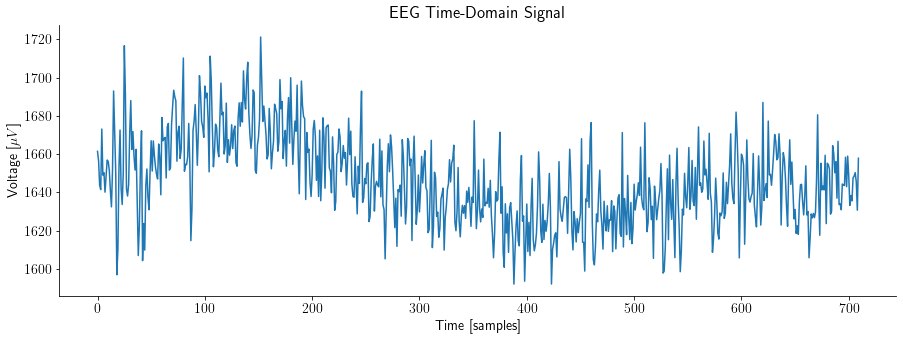

In [38]:
# Plot the Signal in Samples
plt.figure()
plt.plot(eeg_signal)
plt.title('EEG Time-Domain Signal')
plt.xlabel('Time [samples]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

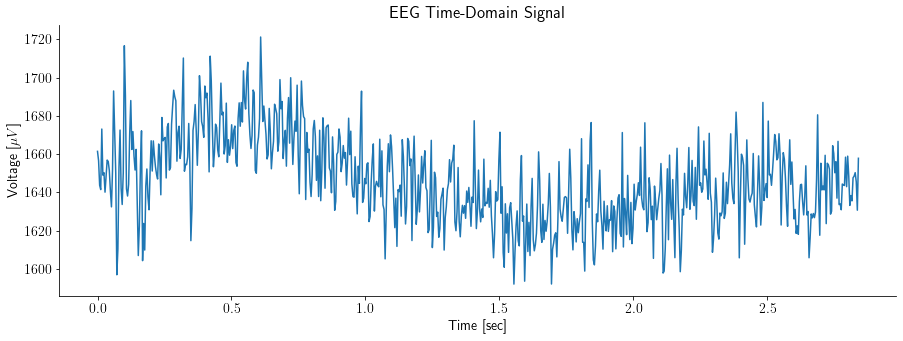

In [39]:
# Plot the Signal in Seconds
plt.figure()
plt.plot(time, eeg_signal)
plt.title('EEG Time-Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

## Plot the Frequency Domain Representation

In [88]:
def calculate_plot_frequency_domain(signal, fs = 1):
      
    fft_output = np.fft.fft(signal) # FFT of Input Samples
    N = len(fft_output) # Number of samples of the DTFT for the DFT
    
    amplitude = np.absolute(fft_output) # calculate the amplitude
    phase = np.angle(fft_output) # calculate the phase
    
    frequencies = np.linspace(0, fs, 710)
    print(N/2)
    half_frequencies = frequencies[0:int(N/2)]
    half_amplitude = amplitude[0:int(N/2)]
    half_phase = phase[0:int(N/2)]
    
    fig, axs = plt.subplots(2) 
    axs[0].set_title('Frequency Representation')
    axs[0].plot(half_frequencies, half_amplitude) # plot amplitude
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'Voltage [$\mu V$]')
    axs[1].plot(half_frequencies, half_phase) # plot phase
    axs[1].set_xlabel('Frequency [Hz]')
    axs[1].set_ylabel(r'Phase [rad]')
    sns.despine()
    plt.show()

355.0


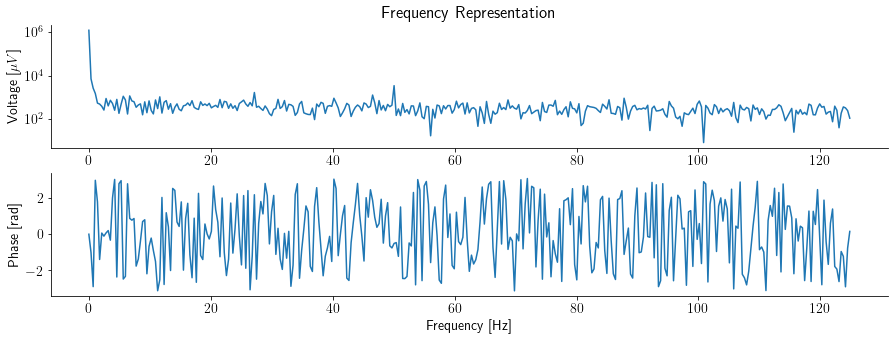

In [89]:
fs = 250
calculate_plot_frequency_domain(eeg_signal, fs)

## Build a Bandpass Filter To Remove the DC Component

In [138]:
def bandpass_chebII(signal_to_filter, Omega_pass, Omega_stop, fs):

    # Passband Omega_p (Hz)
    # Stopband Omega_s (Hz)

    print(" -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- ")

    # Initialize IIR Parameters ------------------------------

    omega_pass     = (2 * Omega_pass) / fs # normalized band
    omega_stop     = (2 * Omega_stop) / fs # normalized band
    max_gain_pass  = 0 # dB
    min_atten_pass = 1 # dB
    ripple_pass    = min_atten_pass - max_gain_pass # dB
    max_atten_stop = 50 # dB

    # Generate Filter Parameters
    ord, ws = signal.cheb2ord(omega_pass, omega_stop, min_atten_pass - max_gain_pass, max_atten_stop)

    # Outputs polynomial coefficients, using the bilinear transform automatically
    b, a = signal.cheby2(ord, max_atten_stop, ws, btype='band',  output='ba')
    
    # Plot Frequency Response with b, a Coefficients
    frequencies, filter_frequency_response = signal.freqz(b, a)
    frequencies_cont = frequencies * fs / (2 * np.pi)
    amplitude = np.abs(filter_frequency_response)
    phase = np.angle(filter_frequency_response)
    
    fig, axs = plt.subplots(2) 
    axs[0].set_title('Bandpass Filter Frequency Representation')
    axs[0].plot(frequencies_cont, 20 * np.log10(amplitude)) # plot amplitude
    axs[0].set_ylabel(r'Power [dB]')
    axs[1].plot(frequencies_cont, phase) # plot phase
    axs[1].set_xlabel('Frequency [Hz]')
    axs[1].set_ylabel(r'Phase [rad]')
    sns.despine()
    
    # Filter Signal
    filtered_signal = signal.filtfilt(b, a, signal_to_filter)

    return filtered_signal

 -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- 
355.0


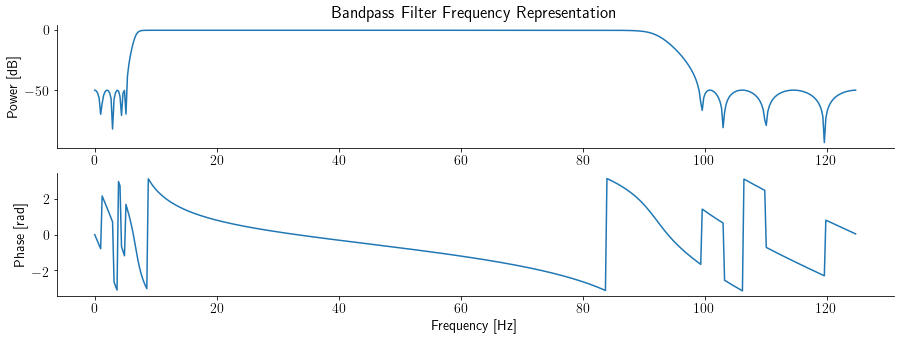

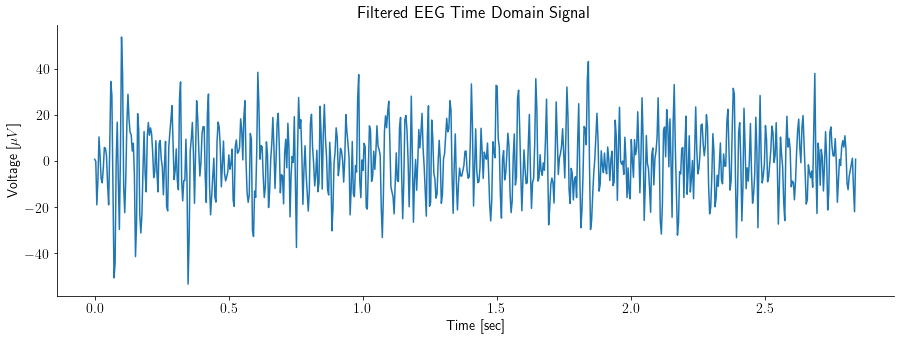

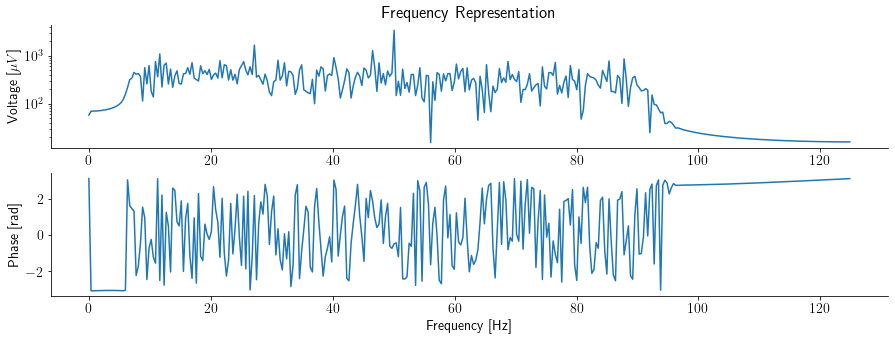

In [139]:
Omega_pass = np.array([7.25, 90])  # Pass Band of Band Pass Filter in [Hz]
Omega_stop = np.array([4, 100])  # Stop Band of Band Pass Filter in [Hz]
filtered_eeg_signal = bandpass_chebII(eeg_signal, Omega_pass, Omega_stop, fs)

# Plot the Signal in Seconds
plt.figure()
plt.plot(time, filtered_eeg_signal)
plt.title('Filtered EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

# Plot Frequency Domain
calculate_plot_frequency_domain(filtered_eeg_signal, fs)

## Build a Bandpass Filter To Isolate a Certain Frequency Band

 -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- 
355.0


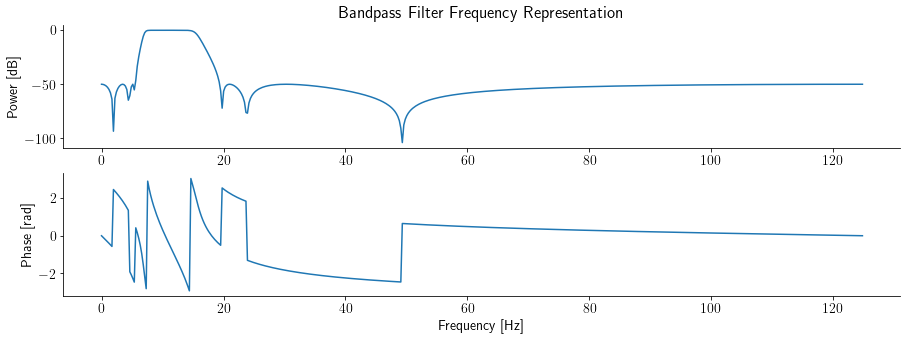

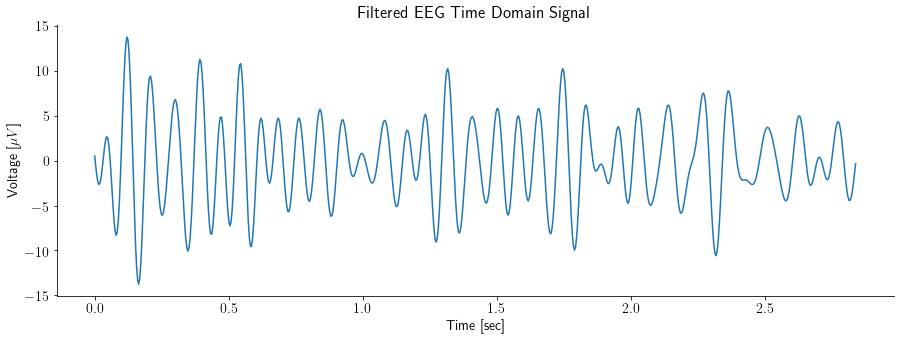

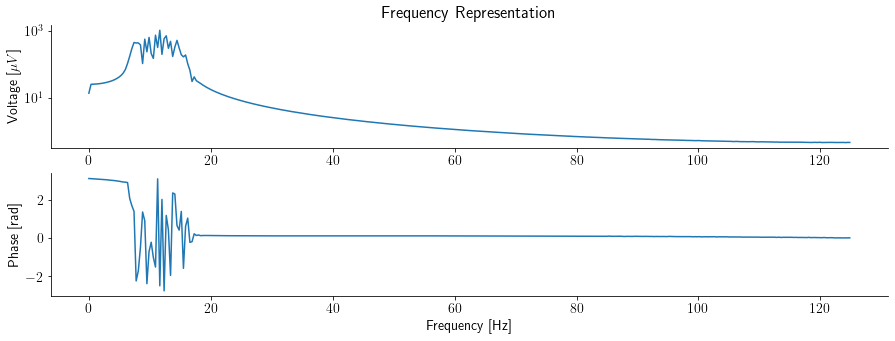

In [140]:
Omega_pass = np.array([7.25, 15])  # Pass Band of Band Pass Filter in [Hz]
Omega_stop = np.array([4, 20])  # Stop Band of Band Pass Filter in [Hz]
filtered_eeg_signal = bandpass_chebII(eeg_signal, Omega_pass, Omega_stop, fs)

# Plot the Signal in Seconds
plt.figure()
plt.plot(time, filtered_eeg_signal)
plt.title('Filtered EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

# Plot Frequency Domain
calculate_plot_frequency_domain(filtered_eeg_signal, fs)

## Generate Figure 4

### Download the Data and Extract all Oz Electrode Data

In [3]:
# Isolate Patient Data ----------------------------------------------------------------------

# Navigate to Patient Data
data_path = './data/Patients'
os.chdir(data_path)

# Get All Patient File Names
patients = os.listdir()

# Initialize a Dictionary
patient_data = {}

# Isolate all the data for 11.25 Hz (Index 1)
for index, patient in enumerate(patients):
    
    data_temp = scipy.io.loadmat(patient)
    eeg_data = data_temp['data']
    patient_data[patient.replace('.mat', '')] = eeg_data
    
    if index == 0:
        
        Oz_patient = eeg_data[5, :, 1, :, 1]
        Oz = np.array(Oz_patient)
        
    else:
        
        Oz_patient = eeg_data[5, :, 1, :, 1]
        Oz = np.append(Oz, Oz_patient, axis = 1)
        
# Load Subject Information
os.chdir('..')
subjects = scipy.io.loadmat('Subjects_Information.mat')

### Average Oz Electrode Data For All Patients and All Blocks

355.0


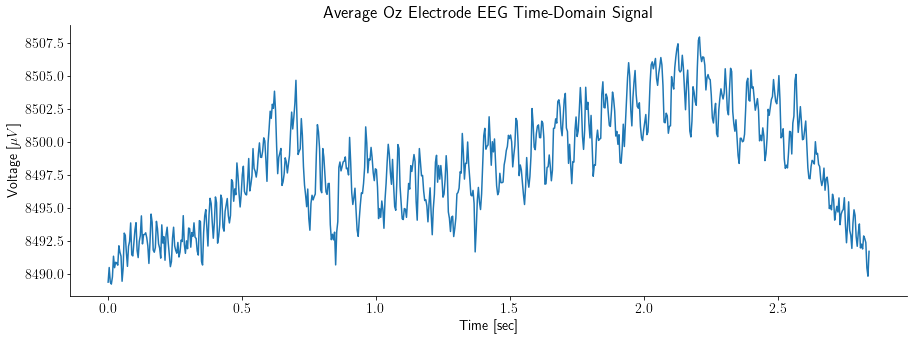

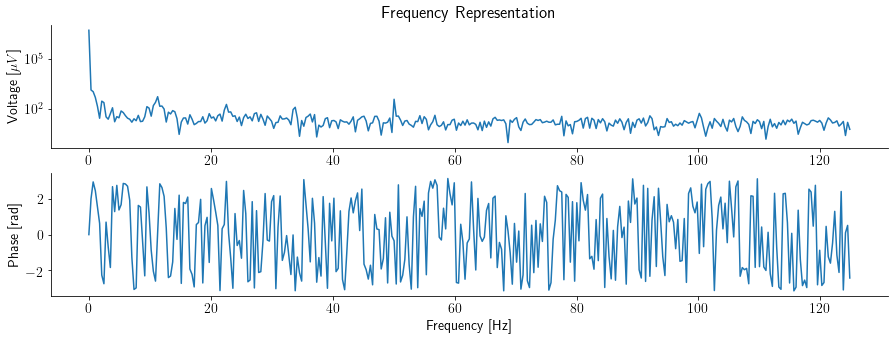

In [113]:
# Average the Data for Every Patient, and Every Block
Oz_average = np.average(Oz, axis = 1)

# Plot the Signal in Seconds
plt.figure()
plt.plot(time, Oz_average)
plt.title('Average Oz Electrode EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

# Plot Frequency Domain
calculate_plot_frequency_domain(Oz_average, fs)

 -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- 
355.0


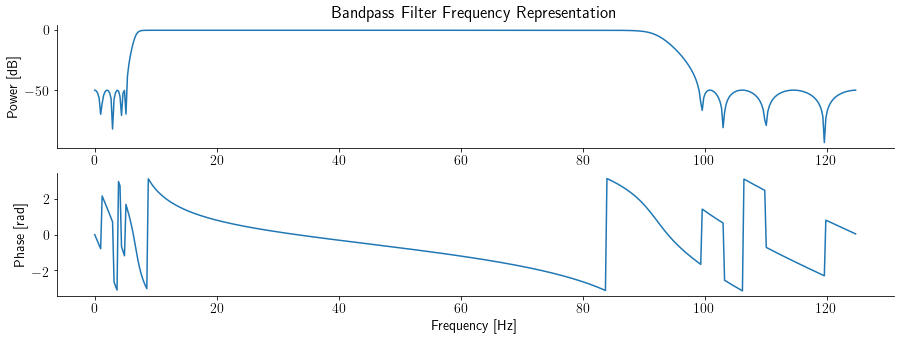

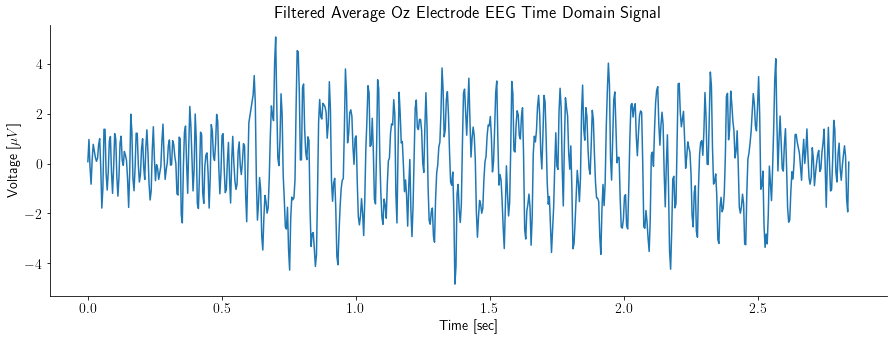

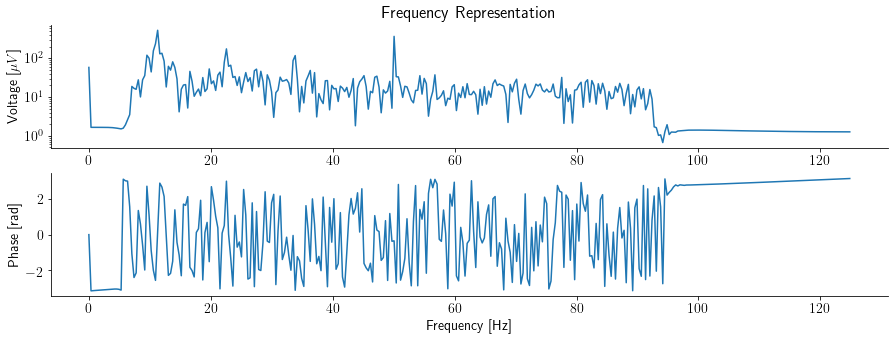

In [141]:
Omega_pass = np.array([7.25, 90])  # Pass Band of Band Pass Filter in [Hz]
Omega_stop = np.array([4, 100])  # Stop Band of Band Pass Filter in [Hz]
filtered_Oz_average = bandpass_chebII(Oz_average, Omega_pass, Omega_stop, fs)

# Plot the Signal in Seconds
plt.figure()
plt.plot(time, filtered_Oz_average)
plt.title('Filtered Average Oz Electrode EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

# Plot Frequency Domain
calculate_plot_frequency_domain(filtered_Oz_average, fs)